This file is aimed to create a plot redshift range of emission lines in 3 CSST/grism bands. 
The figure is created by using files of redshift range for each emission line data.

In [1]:
import numpy as np
import math
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib import cm
from matplotlib.ticker import FuncFormatter,NullFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import pandas as pd
import glob
import re
from scipy.interpolate import interp1d
import h5py
import pysynphot as S
import matplotlib

matplotlib.rcParams['figure.figsize'] = [16, 8]

/Users/rain/miniconda3/envs/grizli/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/rain/grizli/synphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [3]:
"""
Functions for humanly sorting the filenames by dividing strings and numbers in the file names.
"""
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s

def str2int(v_str):
    return [tryint(sub_str) for sub_str in re.split('([0-9]+)', v_str)]

def sort_humanly(v_list):
    return sorted(v_list, key=str2int)

"""
Functions of customizing x scale in log(1+x) form.
"""
def forward(a):
    return np.log(1+a)

def inverse(a):
    return np.exp(a)-1

Emission lines data collected from https://www.stsci.edu/~strolger/docs/UNITS.txt, choose emission lines by deleting '#' for which you want to show in the figure.

In [4]:
emissionline = {
r'Ly$\alpha$ 1216 $\AA$'         :1215.67,
#'OV] 1218 $\AA$'          :1218,
#'NV 1239 $\AA$'         :1238.82,
#'NV 1243 $\AA$'         :1242.80,
#'SiII 1260 $\AA$'       :1260.4,
#'OI 1303 $\AA$'         :1303.5,
#'CII 1335 $\AA$'         :1334.5,
#'CII 1336 $\AA$'         :1335.7,
#'OI 1356 $\AA$'         :1355.6,
#'OI 1358 $\AA$'         :1358.5,
#'SiIV 1394 $\AA$'       :1393.76,
#'SiIV 1403 $\AA$'       :1402.77,
#'OIV] 1393 $\AA$'        :1393.23,
#'OIV] 1400 $\AA$'        :1399.78,
#'OIV] 1401 $\AA$'        :1401.16,
#'OIV] 1405 $\AA$'        :1404.81,
#'OIV] 1407 $\AA$'        :1407.38,
#'NIV] 1488 $\AA$'         :1488,
'CIV 1548, 1551 $\AA$'        :1548.20,
#'FeI 1610 $\AA$'        :1610,
#'HeII 1640 $\AA$'       :1640,
#'OIII] 1661 $\AA$'       :1661,
#'OIII] 1663 $\AA$'       :1663,
#'OIII] 1667 $\AA$'       :1667,
#'NIII] 1750 $\AA$'       :1750,
#'SiII 1808 $\AA$'       :1808,
#'SiII 1817 $\AA$'       :1817,
#'SiIII] 1892 $\AA$'       :1892,
'CIII] 1909 $\AA$'       :1909,
#'NII 2141 $\AA$'        :2141?,
#'FeII 2200-2800 $\AA$'      :(2200-2800),
#'CII] 2326 $\AA$'        :2326,
#'[NeIV] 2439 $\AA$'       :2438.6,
#'[NeIV] 2441 $\AA$'       :2441.3,
#'[OII] 2470 $\AA$'        :2470.3,
#'[OII] 2471 $\AA$'        :2470.4,
#'HeII 2512 $\AA$'       :2512,
#'MgVII 2512 $\AA$'       :2512,
#'HeII 2734 $\AA$'       :2734,
'MgII 2796, 2803 $\AA$'       :2795.528,
#'MgI 2852 $\AA$'         :2852.1262,
#'FeI 2868 $\AA$'        :2868,
#'OIII 3047 $\AA$'       :3047?,
#'OIII 3123 $\AA$'       :3123,
#'OIII 3133 $\AA$'       :3133,
#'HeII 3204 $\AA$'       :3204,
#'NaI 3302 $\AA$'        :3302.37,
#'NaI 3303 $\AA$'        :3302.98,
#'OIII 3312 $\AA$'       :3312,
#'[NeIII] 3343 $\AA$'      :3342.9,
#'[NeV] 3346 $\AA$'        :3345.9,
#'[NeV] 3426 $\AA$'        :3425.8,
#'OIII 3444 $\AA$'       :3444,    
#'[OII] 3726 $\AA$'        :3726.16,
'[OII] 3726,3728 $\AA$'        :3728.91,   ##### [O II] doublet
#'OIII 3760 $\AA$'       :3760,
#'FeVII 3760 $\AA$'      :3760.3,
#'H$\eta$ 3798 $\AA$'         :3797.90,
#'H$\zeta$ 3836 $\AA$'          :3835.38,
'[NeIII] 3868 $\AA$'      :3868.74,
#'H\eta 3890 $\AA$'       :3889.05,
#'HeI 3889 $\AA$'        :3888.65,
#'CaII 3952 $\AA$'       :3952,
#'[NeIII] 3968 $\AA$'      :3967.51,
#'H$\epsil$ 3970 $\AA$'      :3970.07,
#'[SII] 4069 $\AA$'        :4068.60,
#'[SII] 4076 $\AA$'        :4076.35,
#'H$\delta$ 4102 $\AA$'      :4101.73,
#'[FeII] 4250 $\AA$'       :4250,
#'[FeII] 4281 $\AA$'       :4281,
#'G_banD 4304 $\AA$'       :4304,
#'H$\gamma$ 4341 $\AA$'      :4340.46,
#'[OIII] 4364 $\AA$'       :4363.21,
#'HeI 4772 $\AA$'        :4471.5,
#'NV 4619 $\AA$'         :4619,
#'NIII 4640 $\AA$'       :4640,
#'CIII 4650 $\AA$'       :4650,
#'CIV 4658 $\AA$'        :4658,
#'[FeIII] 4658 $\AA$'       :4658.1,
#'HeII 4686 $\AA$'       :4685.7,
#'[ArIV] 4711 $\AA$'       :4711.33,
#'[ArIV] 4740 $\AA$'       :4740.20,
r'H$\beta$ 4862 $\AA$'       :4861.32,
#'[OIII] 4959 $\AA$'      :4958.91,
'[OIII] 4959,5007 $\AA$'      :5005.84,       ##### [O III] doublet
#'[FeVII] 5158 $\AA$'      :5158.3,
#'[FeVIII] 5159 $\AA$'      :5159.0?,
#'Mgb 5167 $\AA$'       :5167.32,
#'Mgb 5178 $\AA$'       :5178.68,
#'MgIb 5184 $\AA$'       :5183.60,
#'[FeVI] 5176 $\AA$'       :5176.4?,
#'[FeVI] 5177 $\AA$'       :5177.0,
#'[ArIII] 5192 $\AA$'      :5191.82,
#'[NI] 5199 $\AA$'         :5198.5,
#'[NI] 5201 $\AA$'         :5200.7,
#'FeIE2 5270 $\AA$'       :5270,
#'[FeVII] 5278 $\AA$'      :5277.8,
#'[FeXIV] 5303 $\AA$'       :5303.0,
#'[CaV] 5309 $\AA$'        :5309.2,
#'[FeVI] 5335 $\AA$'       :5335.2,
#'FeII 4500-5400 $\AA$'      :(4500-5400)
#'[OI] 5577 $\AA$'         :5577.35,
#'[FeVII] 5721 $\AA$'      :5720.9,
#'[NII] 5755 $\AA$'        :5754.8,
#'CIV 5802 $\AA$'        :5801.51,
#'CIV 5812 $\AA$'        :5812.14,
#'HeI 5876 $\AA$'        :5875.7,
#'NaD 5890 $\AA$'        :5889.950,
#'NaD 5896 $\AA$'        :5895.924,
#'[CaV] 6086 $\AA$'        :6085.9,
#'[FeVII] 6087 $\AA$'      :6086.9,
#'O2 6259 $\AA$'         :6258,
#'O2 6280 $\AA$'         :6280,
#'[OI] 6302 $\AA$'         :6300.23,
#'[SIII] 6312 $\AA$'       :6312.1,
#'[OI] 6364 $\AA$'         :6363.88,
#'[FeX] 6375 $\AA$'         :6374.5,
#'Ca+Fe 6495 $\AA$'        :6495,
#'[NII] 6548 $\AA$'        :6548.1,
r'H$\alpha$ 6563 $\AA$'      :6562.80,
'[NII] 6585 $\AA$'        :6583.6,
#'HeI 6678 $\AA$'        :6678.15,
#'TiO 6700 $\AA$'         :6700,
#'CaI 6718 $\AA$'         :6718,
#'[SII] 6716 $\AA$'        :6716.42,
'[SII] 6730 $\AA$'        :6730.78,
#'B_BanD 6868 $\AA$'       :6868,
#'[ArV] 7006 $\AA$'         :7005.67,
#'HeI 7065 $\AA$'        :7065.3,
#'[ArIII] 7136 $\AA$'      :7135.80,
#'[FeII] 7155 $\AA$'       :7155,
#'[CaII] 7291 $\AA$'       :7291.46,
#'[CaII] 7324 $\AA$'       :7323.88,
#'[OII] 7318 $\AA$'        :7318.6,
#'[OII] 7319 $\AA$'        :7319.4,
#'[OII] 7330 $\AA$'        :7329.9,
#'[OII] 7331 $\AA$'        :7330.7,
#'KI 7665 $\AA$'         :7664.872,
#'KI 7699 $\AA$'         :7698.977,
#'[ArIII] 7751 $\AA$'      :7751.06,
#'FeXI' 7892 $\AA$        :7891.9,
#'OI 8446 $\AA$'         :8446,
#'CaII 8498 $\AA$'       :8498.0,
#'CaII 8542 $\AA$'       :8542.1,
#'CaII 8662 $\AA$'       :8662.2,
#'[SIII] 9069 $\AA$'       :9069.4,
#'P9 9229 $\AA$'          :9229.02,
#'[SIII] 9532 $\AA$'       :9532.1,
#'P$\epsil$ 9546 $\AA$'      :9545.98,
#'P$\delta$ 10049 $\AA$'      :10049.4,
#'HeI 10830 $\AA$'        :10830,
#'P$\gamma$ 10938 $\AA$'      :10938.1,
#r'P$\beta$ 12818 $\AA$'       :12818.1,
#r'P$\alpha$ 18751 $\AA$'      :18751.0,
#Bracket-gam 21655 $\AA$      :21655.0
}

elname = list(emissionline.keys())
lambdae = list(emissionline.values())

Read the grism throughput data

In [2]:
work_dict = '/Users/rain/emulator/'
bkg = h5py.File(work_dict + 'bkg_and_tp.hdf5', 'r')

csstgu = S.ArrayBandpass(bkg['bkg_gu_wave'][:],bkg['bkg_gu_throughput'][:])
csstgv = S.ArrayBandpass(bkg['bkg_gv_wave'][:],bkg['bkg_gv_throughput'][:])
csstgi = S.ArrayBandpass(bkg['bkg_gi_wave'][:],bkg['bkg_gi_throughput'][:])
gutp = bkg['bkg_gu_throughput'][:]
gvtp = bkg['bkg_gv_throughput'][:]
gitp = bkg['bkg_gi_throughput'][:]

GUX = csstgu.wave 
GVX = csstgv.wave 
GIX = csstgi.wave 
GUY = csstgu.throughput
GVY = csstgv.throughput
GIY = csstgi.throughput

grism = ['GU', 'GV', 'GI']
grismx = ['GUX', 'GVX', 'GIX']
grismy = ['GUY', 'GVY', 'GIY']
colors = ['Blues', 'Greens', 'Reds']

Updated plot code
1. using redshift data in the loop instead of creating and loading files.
2. setting z = 0.5 x_label as float while other labels are int using FuncFormatter
3. hide the y-axis major label instead of setting the color as 'white'

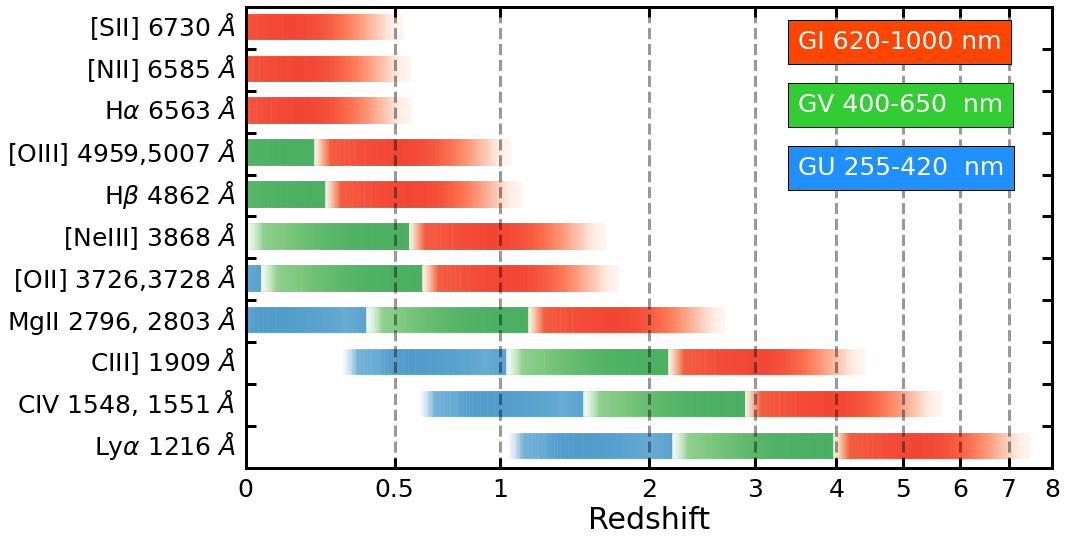

In [89]:
fig, ax = plt.subplots()
# setting the redshift data width in each row
y_width = 1/(len(elname)+1) - 0.03

for i in range(len(grismx)):
    map_vir = cm.get_cmap(name=colors[i])
    # get the throughput data to determine the colormap.
    z1 = globals()[grismy[i]]
    # normalize the throughput data into (0,1) and change the max value of color
    norm = plt.Normalize(min(z1),max(z1))
    norm_values = 0.6*norm(z1)
    colors1 = map_vir(norm_values)
    for k in range(len(lambdae)):
        redshift = []
        for j in range(len(globals()[grismx[i]])):
        # judge if lambda_o>lambda_e
            if globals()[grismx[i]][j]/lambdae[k] > 1 :
                # add elements to the redshift array
                # setting the initial height of redshift data in each row
                y = k/(len(elname)) + 0.021
                ax.axvline(globals()[grismx[i]][j]/lambdae[k] - 1, y, y+y_width, color=colors1[j], zorder=1)

ax.text(3.5, len(elname)-(1+3*1), 'GU 255-420  nm', style='normal', color='white', fontsize = 25,
        bbox={'facecolor': 'dodgerblue', 'pad': 10})
ax.text(3.5, len(elname)-(1+1.5*1), 'GV 400-650  nm', style='normal', color='white', fontsize = 25,
        bbox={'facecolor': 'limegreen',  'pad': 10})
ax.text(3.5, len(elname)-(1+0*1), 'GI 620-1000 nm', style='normal', color='white', fontsize = 25,
        bbox={'facecolor': 'orangered',  'pad': 10})

x_label = [0,0.5,1,2,3,4,5,6,7,8]
for v in x_label:
        ax.axvline(v, linestyle='--',alpha=0.4, color = 'k' ,linewidth = 3)
ax.set_xscale('function', functions = (forward, inverse))
ax.set_xlim(0,8)
ax.xaxis.set_major_locator(ticker.FixedLocator(x_label))
# setting x = 0.5 as float while others are int
def custom_formatter(x, pos):
    if x == 0.5:
        return f'{x:.1f}'
    else:
        return f'{x:.0f}'
ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
ax.set_xlabel('Redshift',fontsize=30)

ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

ax.set_ylim(0,len(elname))
y_label = np.arange(len(elname))
ellocation = y_label+0.6
ax.yaxis.set_major_locator(ticker.FixedLocator(y_label))
ax.yaxis.set_minor_locator(ticker.FixedLocator(ellocation))
ax.set_yticks(ellocation, major=False, minor = True)
ax.set_yticklabels(elname, minor = True, fontsize=25)
# hide the major y axis label
ax.yaxis.set_major_formatter(NullFormatter())
# ax.set_ylabel('Emission lines',fontsize=20)

ax.tick_params(which='major',direction='in', length=10, width=3, top=True, right=True, zorder = 2, pad = 10)
ax.tick_params(which='minor',direction='in', right=False, left=False, zorder = 2, pad = 10)
ax.tick_params(labelsize=25)

# plt.title('Redshift range of major emission lines for CSST grisms',fontsize=20,pad=10)
plt.subplots_adjust(top=0.95,bottom=0.15,left=0.25,right=0.95,hspace=0,wspace=0)
plt.savefig(work_dict+'zcoverage.pdf')
plt.show()

In [4]:
from astropy.table import Table
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import interp1d
c = 2.9979e8 # m/s
c_aa = 2.9979e18 #AA/s
h = 6.626e-27 # erg*s

def fnu2fphot(wave,fnu): return (fnu / (wave*h))
def flam2fnu(wave,flam): return (wave**2/c_aa)*flam

In [7]:
skyb_total = Table.read('/Users/rain/CSST/skyb/total1.csv')
bkg = h5py.File('/Users/rain/emulator/bkg_and_tp.hdf5', 'r')
bkgwave = np.hstack((2445,skyb_total['wavelength']*10))
bkgflam = np.hstack((skyb_total['intensity'][0]*1e-17,skyb_total['intensity']*1e-17))
bkgf = interpolate.interp1d(bkgwave,flam2fnu(bkgwave, bkgflam))
gutp_0th = Table.read('/Users/rain/emulator/GU.Throughput.0st.fits')
gvtp_0th = Table.read('/Users/rain/emulator/GV.Throughput.0st.fits')
gitp_0th = Table.read('/Users/rain/CSSTSIM/ObservationSim/Instrument/data/sls_conf/GI.Throughput.0st.fits')

gutp_1st = Table.read('/Users/rain/emulator/GU.Throughput.1st.fits')
gvtp_1st = Table.read('/Users/rain/emulator/GV.Throughput.1st.fits')
gitp_1st = Table.read('/Users/rain/emulator/GI.Throughput.1st.fits')

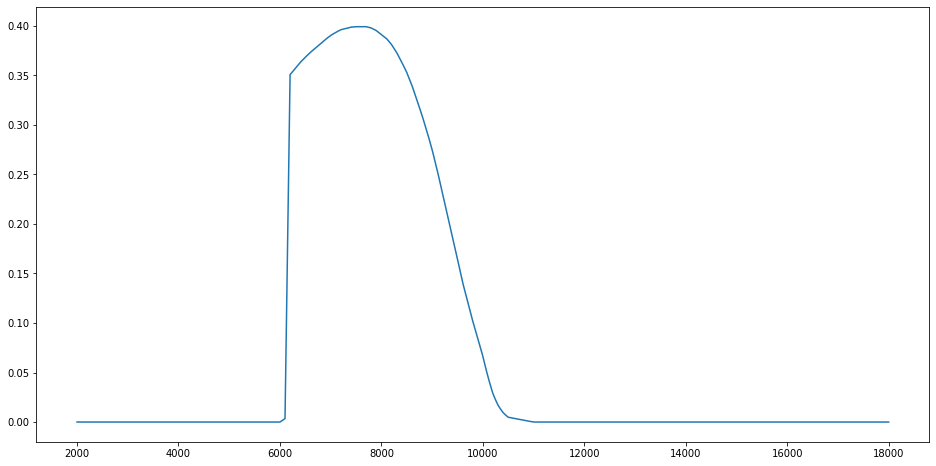

In [50]:
plt.plot(gitp_1st['WAVELENGTH'],gitp_1st['SENSITIVITY'])

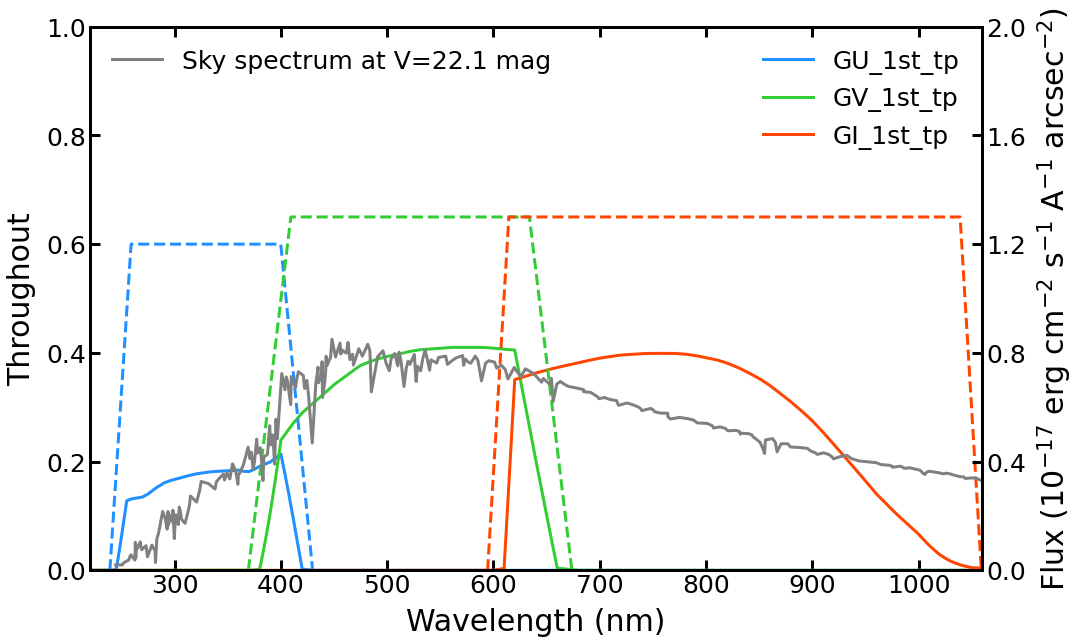

In [9]:
plt.figure(figsize=(16,10))

ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.tick_params(labelsize=25)
ax.tick_params(which='major',direction='in', length=10, width=3, top=True, right=True)
ax.tick_params(which='minor',direction='in', top=True, right=True)
ax.set_ylim(0,1)
ax.set_xlim(220, 1060)
ax.set_xticks([300,400,500,600,700,800,900,1000])
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xlabel('Wavelength (nm)',fontsize=30,labelpad=10)
ax.set_ylabel('Throughout',fontsize=30,labelpad=10)

ax.plot(gutp_1st['WAVELENGTH']/10,gutp_1st['SENSITIVITY'],c='dodgerblue',label='GU_1st_tp',linewidth=3,linestyle='-',zorder=2)
ax.plot(gvtp_1st['WAVELENGTH']/10,gvtp_1st['SENSITIVITY'],c='limegreen',label='GV_1st_tp',linewidth=3,linestyle='-',zorder=2)
ax.plot(gitp_1st['WAVELENGTH']/10,gitp_1st['SENSITIVITY'],c='orangered',label='GI_1st_tp',linewidth=3,linestyle='-',zorder=2)
ax.plot([bkg['bkg_gu_wave'][:].min()/10-10, bkg['bkg_gu_wave'][:].min()/10+10,bkg['bkg_gu_wave'][:].max()/10-30,bkg['bkg_gu_wave'][:].max()/10],[0,0.6,0.6,0],c='dodgerblue',linewidth=3,linestyle='--',zorder=2)
ax.plot([bkg['bkg_gv_wave'][:].min()/10-20, bkg['bkg_gv_wave'][:].min()/10+20,bkg['bkg_gv_wave'][:].max()/10-30,bkg['bkg_gv_wave'][:].max()/10+10],[0,0.65,0.65,0],c='limegreen',linewidth=3,linestyle='--',zorder=2)
ax.plot([bkg['bkg_gi_wave'][:].min()/10-10, bkg['bkg_gi_wave'][:].min()/10+10,bkg['bkg_gi_wave'][:].max()/10+10,bkg['bkg_gi_wave'][:].max()/10+30],[0,0.65,0.65,0],c='orangered',linewidth=3,linestyle='--',zorder=2)

ax2 = ax.twinx()
# ,flam2fnu(bkgwave,bkgflam)
ax2.plot(bkgwave/10,bkgflam*1e17,c='gray',label='Sky spectrum at V=22.1 mag',linewidth=3,zorder=1)
# ax2.plot(bkg['bkg_gi_wave'][:]/10,bkg['bkg_gi_fnu_per_arcsec'][:]*c_aa/(bkg['bkg_gi_wave'][:]**2)*1e17,c='gray',linewidth=2)
ax2.tick_params(labelsize=25)
ax2.spines['right'].set_linewidth(3)
ax2.set_ylim(0,2)
ax2.set_yticks([0.0,0.4,0.8,1.2,1.6,2.0])
ax2.tick_params(which='major',direction='in', length=10, width=3, top=True, right=True)
ax2.tick_params(which='minor',direction='in', top=True, right=True)

#plt.yscale('log')
ax2.set_ylabel('Flux (10$^{-17}$ erg cm$^{-2}$ s$^{-1}$ A$^{-1}$ arcsec$^{-2}$)',fontsize=30,labelpad=10)

ax.legend(prop={'size':25}, framealpha=0, loc='upper right')
ax2.legend(prop={'size':25}, framealpha=0, loc='upper left')

plt.savefig('/Users/rain/emulator/bkg_tp.pdf')


Saving files process (previous version)

Detect whether working directories and emission line redshift range files exist, if so, delete all the files.

In [ ]:
for i in range(len(grismx)):
    if os.path.exists(str(work_dict)+str(grismx[i])):
        print(str(work_dict)+str(grismx[i])+'/ already exsits!')
    else:
        os.mkdir(str(work_dict)+str(grismx[i]))
        print(str(work_dict)+str(grismx[i])+'/ is created!')
    filenames = sorted(glob.glob(str(work_dict)+str(grismx[i])+"/*"))
    for j in range(len(filenames)):
        if os.path.exists(filenames[j]):
            os.remove(filenames[j])

Calculate and save results of each emission lines redshifts of 3 CSST/grism band and save into files.

z = $\lambda_o$ / $\lambda_e$-1

In [ ]:
redshift = []

for i in range(len(grismx)):
    for j in range(len(lambdae)):
        redshift = []
        for k in range(len(globals()[grismx[i]])):
            #judge if lambda_o>lambda_e
            if 10*globals()[grismx[i]][k]/lambdae[j] > 1 :
                #add elements to the redshift array
                redshift.append(10*globals()[grismx[i]][k]/lambdae[j] - 1)
                #save each file in name of 'grism'+'emission line number'+'emission line name'.
                name = str(work_dict)+str(grismx[i])+'/'+str(grismx[i])+'_'+str(j)+'_emission_line_'+str(elname[j])+'.csv'
                np.savetxt(name, redshift, header = 'redshift' )
        print(str(work_dict)+str(grismx[i])+'/'+str(grismx[i])+'_'+str(j)+'_emission_line_'+str(elname[j])+' is created!')

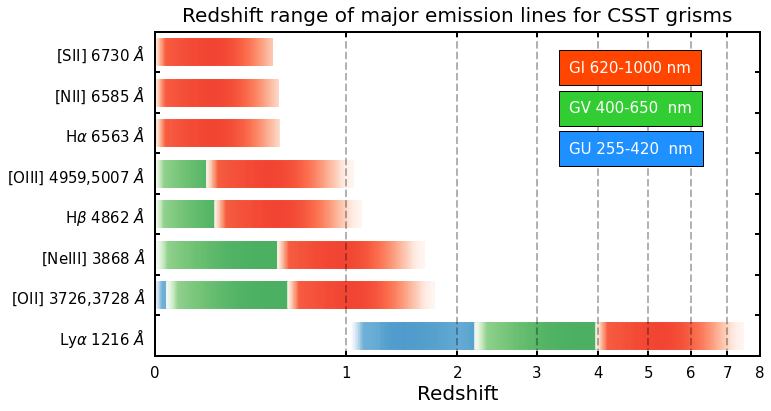

In [108]:
redshiftx=[]
# fig, ax = plt.subplots(figsize=(len(elname), len(elname)/2))
fig, ax = plt.subplots()
# setting the redshift data width in each row
y_width = 1/(len(elname)+1) - 0.03

for j in range(len(grismx)):
    filenames = sorted(glob.glob(work_dict+str(grismx[j])+"/*"))
    filenames = sort_humanly(filenames[0:len(filenames)])
    map_vir = cm.get_cmap(name=colors[j])
    # get the throughput data to determine the colormap.
    z1 = globals()[grismy[j]]
    # normalize the throughput data into (0,1) and change the max value of color
    norm = plt.Normalize(min(z1),max(z1))
    norm_values = 0.6*norm(z1)
    colors1 = map_vir(norm_values)

    for i in range(len(filenames)):
        redshiftx=[]
        redshiftx = np.loadtxt(fname=filenames[i],usecols=(0))
        # setting the initial height of redshift data in each row
        y = i/(len(elname)) + 0.021
        for k in range(len(redshiftx)):
            ax.axvline(redshiftx[k], y, y+y_width, color=colors1[k], zorder=1)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax.tick_params(which='major',direction='in', length=5, width=2, top=True, right=True, zorder = 2, pad = 10)
ax.tick_params(which='minor',direction='in', right=False, left=False, zorder = 2, pad = 10)
ax.tick_params(labelsize=15)

for v in range(1,8):
        ax.axvline(v, linestyle='--',alpha=0.3, color = 'k' ,linewidth=2)

ax.set_xlim(0,8)
ax.set_ylim(0,len(elname))
ax.set_xscale('function', functions = (forward, inverse))

yticks = []
for p in range(len(elname)):
        yticks.append(p+0.5)
ax.set_yticks(yticks, minor = True)
ax.set_yticklabels(elname, minor = True, fontsize=15)
y_label = np.arange(len(elname))
plt.yticks(color='w')
ax.yaxis.set_major_locator(ticker.FixedLocator(y_label))
ax.yaxis.set_minor_locator(ticker.FixedLocator(yticks))
ax.set_xlabel('Redshift',fontsize=20)
# ax.set_ylabel('Emission lines',fontsize=20)

ax.text(3.5, len(elname)-(1+2*1), 'GU 255-420  nm', style='normal', color='white', fontsize = 15,
        bbox={'facecolor': 'dodgerblue', 'pad': 10})
ax.text(3.5, len(elname)-(1+1*1), 'GV 400-650  nm', style='normal', color='white', fontsize = 15,
        bbox={'facecolor': 'limegreen',  'pad': 10})
ax.text(3.5, len(elname)-(1+0*1), 'GI 620-1000 nm', style='normal', color='white', fontsize = 15,
        bbox={'facecolor': 'orangered',  'pad': 10})

plt.title('Redshift range of major emission lines for CSST grisms',fontsize=20,pad=10)
plt.subplots_adjust(top=0.9,bottom=0.15,left=0.2,right=0.9,hspace=0,wspace=0)
# plt.savefig(work_dict+'zcoverage.pdf')
plt.show()